In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip "gdrive/MyDrive/datasets/challenges-in-representation-learning-facial-expression-recognition-challenge.zip" -d 'datasets'

Archive:  gdrive/MyDrive/datasets/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: datasets/example_submission.csv  
  inflating: datasets/fer2013.tar.gz  
  inflating: datasets/icml_face_data.csv  
  inflating: datasets/test.csv       
  inflating: datasets/train.csv      


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

!pip install git+https://github.com/tensorflow/docs

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

!pip install mlxtend --upgrade --no-deps
import mlxtend                                                      
print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ilk9uzr3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ilk9uzr3
  Resolved https://github.com/tensorflow/docs to commit 9b5b8b055e29d006b94b5dfc906d774ee4094bae
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=178984 sha256=38950bc1eaff107c9a90a21791f5c6a333027f47d8be7098cc13b45aa85668af
  Stored in directory: /tmp/pip-ephem-wheel-cache-txjxthpl/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing insta

In [ ]:
root_dir = '/content/datasets/'
full_data_file_name = 'icml_face_data.csv'
train_data_file_name = 'train.csv'
test_data_file_name = 'test.csv'

In [ ]:
df = pd.read_csv(root_dir + full_data_file_name)
df.columns = ('emotion', 'Usage', 'pixels')
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
#split data into training, validation and test set
data_train = df[df['Usage']=='Training'].copy()
data_val   = df[df['Usage']=='PublicTest'].copy()
data_test  = df[df['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = keras.utils.to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Load the EfficientNetB0 model
effnet_model = EfficientNetB0(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

input_tensor = keras.layers.Input(shape=(48, 48, 1))

x = Conv2D(3, (3, 3), padding='same')(input_tensor)
out = effnet_model(x)
model_ = Model(inputs=input_tensor, outputs=out)

# Add custom layers on top of the EfficientNetB0 model
model = tf.keras.models.Sequential([
    model_,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])
#compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
#%%
!pip install git+https://github.com/tensorflow/docs

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
epochs = 100

#checkpoint to save best weights
checkpoint = ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             verbose=1)

#reduce learning rate if plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              mode='min')

#stop training if accuracy does not improve
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=10,
                          mode='max',
                          verbose=1)

#define callbacks
callbacks = [tfdocs.modeling.EpochDots(), 
             earlystop, 
             checkpoint, 
             reduce_lr]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-42e5wgbr
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-42e5wgbr
  Resolved https://github.com/tensorflow/docs to commit 9b5b8b055e29d006b94b5dfc906d774ee4094bae
  Preparing metadata (setup.py) ... done


In [ ]:
# data generator
datagen = ImageDataGenerator(rotation_range=25, 
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True)

datagen.fit(train_X)
datagen.fit(val_X)



history = model.fit(train_X, train_Y,
                    validation_data=(val_X, val_Y),
                    steps_per_epoch=len(train_X) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/100
449/448 [==============================] - ETA: 0s - loss: 2.1524 - accuracy: 0.1717
Epoch: 0, accuracy:0.1717,  loss:2.1524,  val_accuracy:0.1555,  val_loss:2.0615,  
.
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 94s 57ms/step - loss: 2.1524 - accuracy: 0.1717 - val_loss: 2.0615 - val_accuracy: 0.1555 - lr: 1.0000e-05
Epoch 2/100
449/448 [==============================] - ETA: 0s - loss: 2.0189 - accuracy: 0.2080.
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 25s 55ms/step - loss: 2.0189 - accuracy: 0.2080 - val_loss: 1.8814 - val_accuracy: 0.2288 - lr: 1.0000e-05
Epoch 3/100
449/448 [==============================] - ETA: 0s - loss: 1.9562 - accuracy: 0.2287.
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 22s 48ms/step - loss: 1.9562 - accuracy: 0.2287 - val_loss: 1.8449 - val_accuracy: 0.2441 - lr: 1.0000e-05
Epoch 4/100
448/448 [=========================

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
test_acc

113/113 [==============================] - 2s 17ms/step - loss: 1.4345 - accuracy: 0.4820


0.48202842473983765

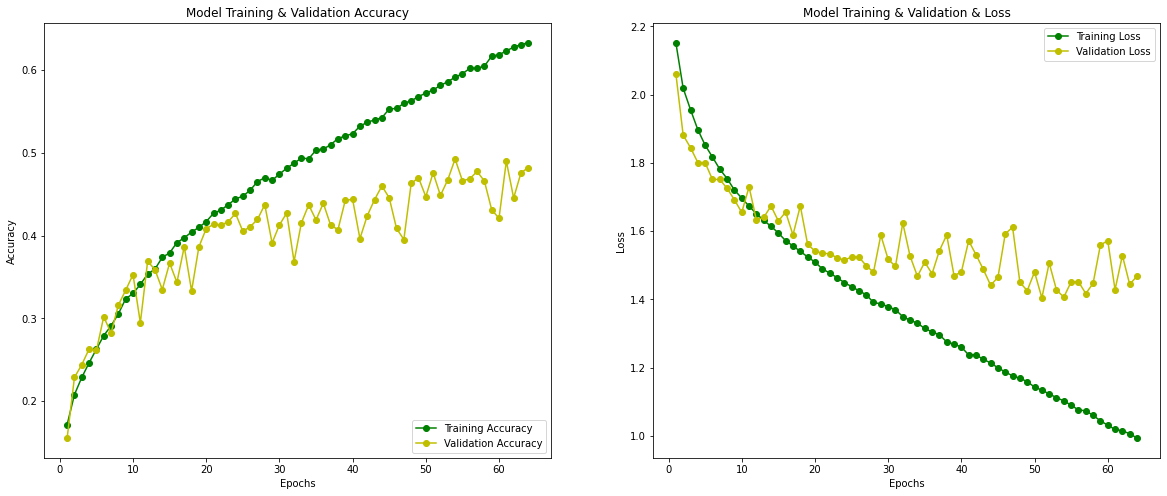

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
model.save('model')
model.save('modelh5', save_format='h5')
# model = keras.models.load_model("model")

TypeError: ignored

In [ ]:
#make prediction
test_y = np.argmax(test_Y, axis=1)
test_yhat = np.argmax(model.predict(test_X), axis=1)

113/113 [==============================] - 3s 11ms/step


[[154   0  53  67  88  35  94]
 [ 12   5   3   5  22   3   5]
 [ 56   0 152  54 113  64  89]
 [ 44   0  36 616  73  31  79]
 [ 63   0  73  61 229  24 144]
 [ 18   0  52  25  27 263  31]
 [ 45   0  55  80 100  35 311]]


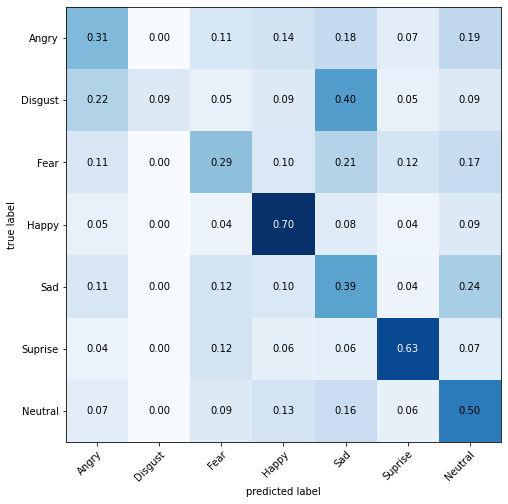

In [ ]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Suprise',
    6: 'Neutral'
}

#get confusion matrix
cm = confusion_matrix(test_y, test_yhat)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [ ]:
!zip -r /content/model_04.zip /content/model